# Model Training & Evaluation

In [1]:
import os
import pytorch_lightning as pl
import torch
import torchvision.transforms as T
from pytorch_lightning.callbacks import LearningRateMonitor

from dogs_cats_classifier.data import DogsCatsImagesDataModule
from dogs_cats_classifier.models import ResNet, Swin, ResNext
from dogs_cats_classifier.utils import evaluate_model
from datetime import datetime

# Setup
## Training setting

In [2]:
batch_size = 16
max_epochs = 10
num_workers = os.cpu_count()//4
image_size = (256, 256)
dataset_root = '../datasets/final/train'
fast_dev_run = False
seed = 168
model_type = 'resnet50'
accelerator = 'auto'
devices = None
output_path = '../model_weights'
use_lr_scheduler = True
use_auto_augment = True
finetune_last_layer = True
user_pretrained_weight = True

## Check output path

In [3]:
exp_time = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
print(exp_time)
output_path = os.path.join(output_path, f'{model_type}_{exp_time}')
# check output
if not os.path.exists(output_path):
    os.makedirs(output_path)

2022-11-01_11-59-48


## Setup random seed for reproducibility

In [4]:
# set all random seed
pl.seed_everything(seed, workers=True)

Global seed set to 168


168

## Setup dataset

In [5]:
# prepare dataset
train_t = []
if use_auto_augment:
    train_t.append(T.AutoAugment(T.AutoAugmentPolicy.IMAGENET))

train_t.append(T.Resize(image_size))
train_t.append(T.ToTensor())
train_t = T.Compose(train_t)
print('Training Data Augmentations')
print(train_t)

test_t = T.Compose([
    T.Resize(image_size),
    T.ToTensor(),
])

dogs_cats_datamodule = DogsCatsImagesDataModule(
    root=dataset_root,
    batch_size=batch_size,
    num_workers=num_workers,
    train_transforms=train_t,
    test_transforms=test_t,
    val_transforms=test_t,
    random_seed=seed,
)
print(dogs_cats_datamodule)

Training Data Augmentations
Compose(
    AutoAugment(policy=AutoAugmentPolicy.IMAGENET, fill=None)
    Resize(size=(256, 256), interpolation=bilinear, max_size=None, antialias=None)
    ToTensor()
)
Dogs Cats Classification
#Labels: 1 = dog, 0 = cat
#Train: 20000
#Val: 2500
#Test: 2500


## Setup Model

In [6]:
# prepare model
if 'swin' in model_type:
    model = Swin
elif 'resnext' in model_type:
    model = ResNext
elif 'resnet' in model_type:
    model = ResNet
else:
    raise ValueError(f'{model_type} is not available.')

model = model(
    num_classes=1,
    model_type=model_type,
    input_shape=image_size,
    max_epochs=max_epochs,
    use_lr_scheduler=use_lr_scheduler,
    user_pretrained_weight=user_pretrained_weight,
    finetune_last_layer=finetune_last_layer,
)

# use pytorch lightning trainer
trainer = pl.Trainer(
    default_root_dir=output_path,
    accelerator=accelerator,
    devices=devices,
    max_epochs=max_epochs,
    auto_scale_batch_size=True,
    fast_dev_run=fast_dev_run,
    callbacks=[LearningRateMonitor(logging_interval='epoch')],
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


# Training

In [7]:
# training
trainer.fit(model, datamodule=dogs_cats_datamodule)

Missing logger folder: ..\model_weights\resnet50_2022-11-01_11-59-48\lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type    | Params | In sizes         | Out sizes
---------------------------------------------------------------------
0 | model     | ResNet  | 23.5 M | [1, 3, 256, 256] | [1, 1]   
1 | loss_func | BCELoss | 0      | ?                | ?        
---------------------------------------------------------------------
2.0 K     Trainable params
23.5 M    Non-trainable params
23.5 M    Total params
94.040    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


## Save scripted model weight

In [8]:
# save for use in production environment
script_model = model.to_torchscript()
torch.jit.save(script_model, os.path.join(output_path, 'model.pt'))

# Evaluation

100%|██████████| 1250/1250 [00:40<00:00, 30.75it/s]


Title: resnet50_train
Accuracy: 0.986
Precision: 0.9840700915969733
Recall: 0.9880047980807677
AUC: 0.9990114048418248


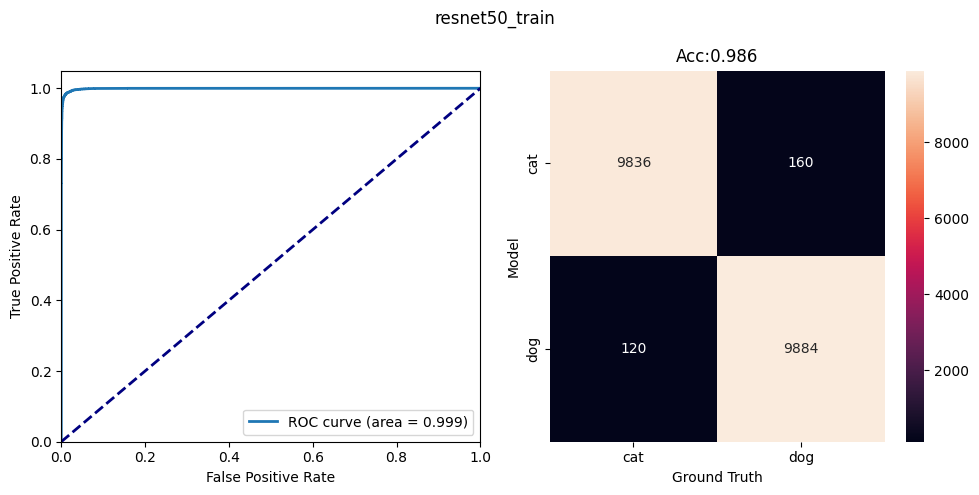

100%|██████████| 157/157 [00:14<00:00, 10.59it/s]


Title: resnet50_val
Accuracy: 0.9912
Precision: 0.9881610102604578
Recall: 0.9944400317712471
AUC: 0.9995065344187443


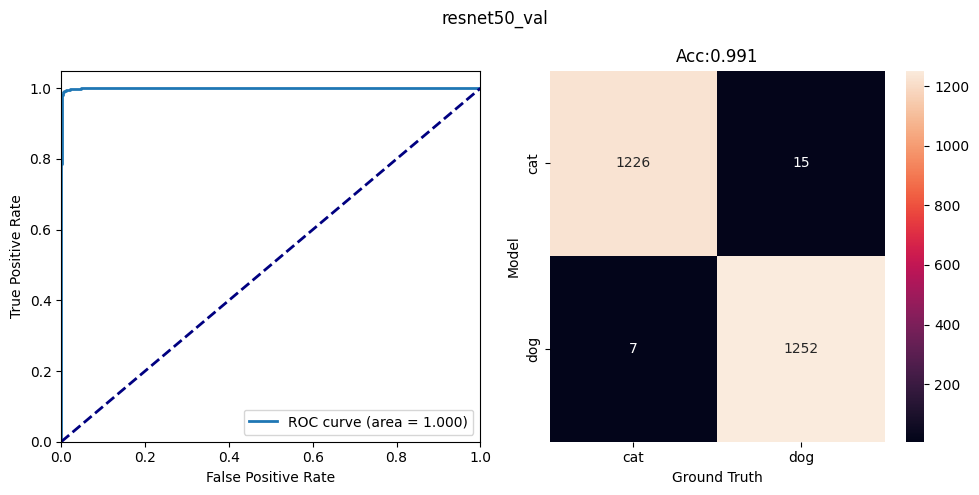

100%|██████████| 157/157 [00:14<00:00, 10.90it/s]


Title: resnet50_test
Accuracy: 0.9944
Precision: 0.9911646586345382
Recall: 0.9975747776879548
AUC: 0.9996441215081823


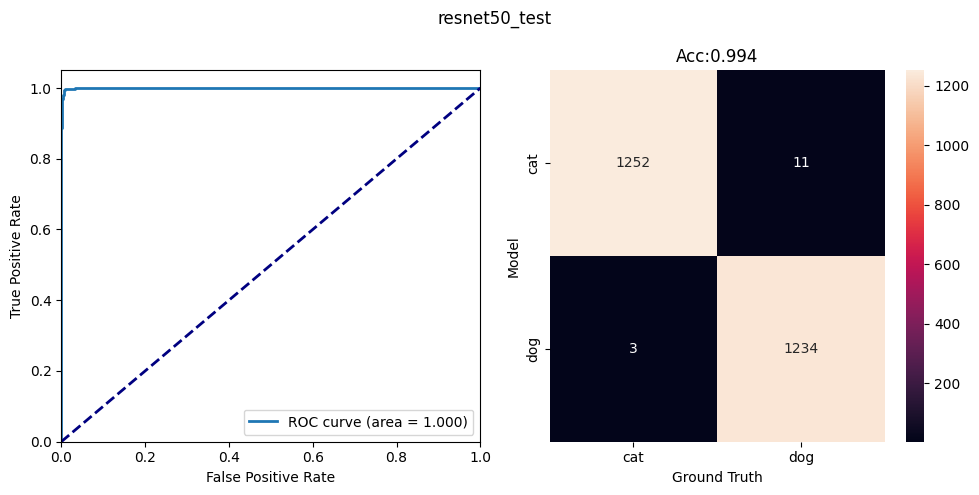

In [9]:
# evaluation
dogs_cats_datamodule.setup()

evaluate_model(model=model,
               dataloader=dogs_cats_datamodule.train_dataloader(),
               title=f'{model_type}_train',
               output_path=output_path,
               verbose=True)
evaluate_model(model=model,
               dataloader=dogs_cats_datamodule.val_dataloader(),
               title=f'{model_type}_val',
               output_path=output_path,
               verbose=True)
evaluate_model(model=model,
               dataloader=dogs_cats_datamodule.test_dataloader(),
               title=f'{model_type}_test',
               output_path=output_path,
               verbose=True)